In [1]:
from google.cloud import storage
import csv
import datetime
from dotenv import load_dotenv

load_dotenv() 

CERTIFICATE_JSON = os.getenv('CERTIFICATE_JSON')
DATABASE_URL = os.getenv('DATABASE_URL')

# Import database module.
import firebase_admin
from firebase_admin import credentials
from firebase_admin import db

cred = credentials.Certificate(CERTIFICATE_JSON)
firebase_app = firebase_admin.initialize_app(cred, {'databaseURL': DATABASE_URL})



In [2]:
from datetime import timezone
import pytz


def unixtimems_to_timestamp(utime, timezone_str):
    utc_dt = datetime.datetime.utcfromtimestamp(utime) 
    return utc_dt


def get_latencies(source_times, timezone_str):
    source_label = source_times[0]
    source_key = source_times[1]
    time_start = source_times[2]
    time_end = source_times[3]
    ref = db.reference(source_key)

    snapshot = ref.order_by_key().get()
    
    latencies = []
    time_seq = []
    for key, val in snapshot.items():
        cur_ts = int(key)
        if cur_ts < time_start or time_end < cur_ts:
            continue
        time_seq.append(unixtimems_to_timestamp(cur_ts // 1000, timezone_str))
        latencies.append(val['latency'])
        
    return (source_label, time_seq, latencies)

In [3]:
latencies_by_sources_jst = []
latencies_by_sources_cdt = []

sources_jst = [
    ('eth', 'soracom1', 1629292804000, 1629552184000), # 8/18 8:20 - 8/21 8:23
    ('jp,ak-020,4xfast', 'soracom4', 1629292984000, 1629379384000), #  8/18 8:23 - 8/19 8:23
    ('jp,ak-020,slow', 'soracom4', 1629379384000, 1629552184000), # 8/19 8:23 - 8/21 8:23
    ]

sources_cdt = [
    ('eth', 'soracom1', 1629292804000, 1629602565000), # 8/18 8:20 - 8/21 22:20
    ('us,yifan,4xfast', 'soracom2', 1629292804000, 1629465604000), # 8/18 8:20 - 8/19 8:20
    ('us,yifan,slow', 'soracom2', 1629465604000, 1629552004000), # 8/19 8:20 - 8/21 8:20
    ('us,GLinet,slow', 'soracom6', 1629550804000, 1629602565000), #  8/21 8:00 - 8/21 22:20
    ]

for source_times in sources_jst:
    latencies_by_sources_jst.append(get_latencies(source_times, 'JST'))
    

for source_times in sources_cdt:
    latencies_by_sources_cdt.append(get_latencies(source_times, 'CDT'))

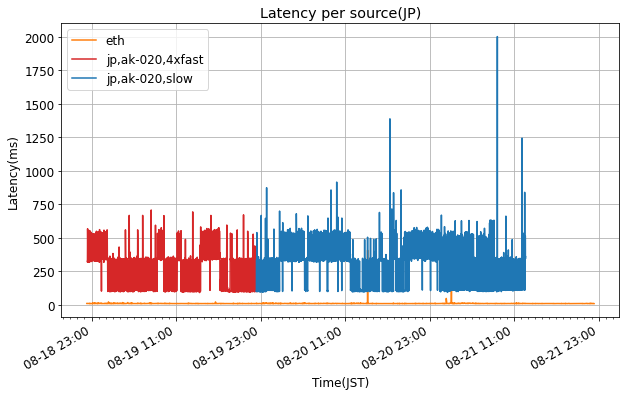

In [4]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

plt.rc('font', size=12)
fig, ax = plt.subplots(figsize=(10, 6))

colors = ['tab:orange', 'tab:red', 'tab:blue', 'tab:green', 'tab:purple', 'tab:brown']
for i, series in enumerate(latencies_by_sources_jst):
    label = series[0]
    x = series[1]
    y = series[2]
    ax.plot(x, y, color=colors[i], label=label)

ax.set_xlabel('Time(JST)')
ax.set_ylabel('Latency(ms)')
ax.set_title('Latency per source(JP)')

plt.gca().xaxis_date('Asia/Tokyo')

twelve_hours = mdates.HourLocator(interval = 12)
ax.xaxis.set_major_locator(twelve_hours)

hours = mdates.HourLocator(interval = 1)
ax.xaxis.set_minor_locator(hours)

from dateutil import tz
h_fmt = mdates.DateFormatter('%m-%d %H:%M', tz=tz.gettz('Asia/Tokyo'))
ax.xaxis.set_major_formatter(h_fmt)

fig.autofmt_xdate()

ax.grid(True)
ax.legend(loc='upper left')
plt.savefig('latency_per_source_jp.png')

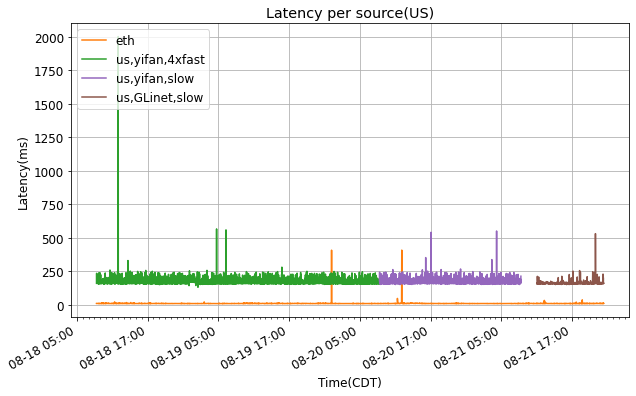

In [5]:
plt.rc('font', size=12)
fig, ax = plt.subplots(figsize=(10, 6))

colors = ['tab:orange','tab:green', 'tab:purple', 'tab:brown']

for i, series in enumerate(latencies_by_sources_cdt):
    label = series[0]
    x = series[1]
    y = series[2]
    ax.plot(x, y, color=colors[i], label=label)

ax.set_xlabel('Time(CDT)')
ax.set_ylabel('Latency(ms)')
ax.set_title('Latency per source(US)')

twelve_hours = mdates.HourLocator(interval = 12)
ax.xaxis.set_major_locator(twelve_hours)

hours = mdates.HourLocator(interval = 1)
ax.xaxis.set_minor_locator(hours)

h_fmt = mdates.DateFormatter('%m-%d %H:%M', tz=tz.gettz('America/Chicago'))
ax.xaxis.set_major_formatter(h_fmt)
fig.autofmt_xdate()

ax.grid(True)
ax.legend(loc='upper left');
plt.savefig('latency_per_source_us.png')

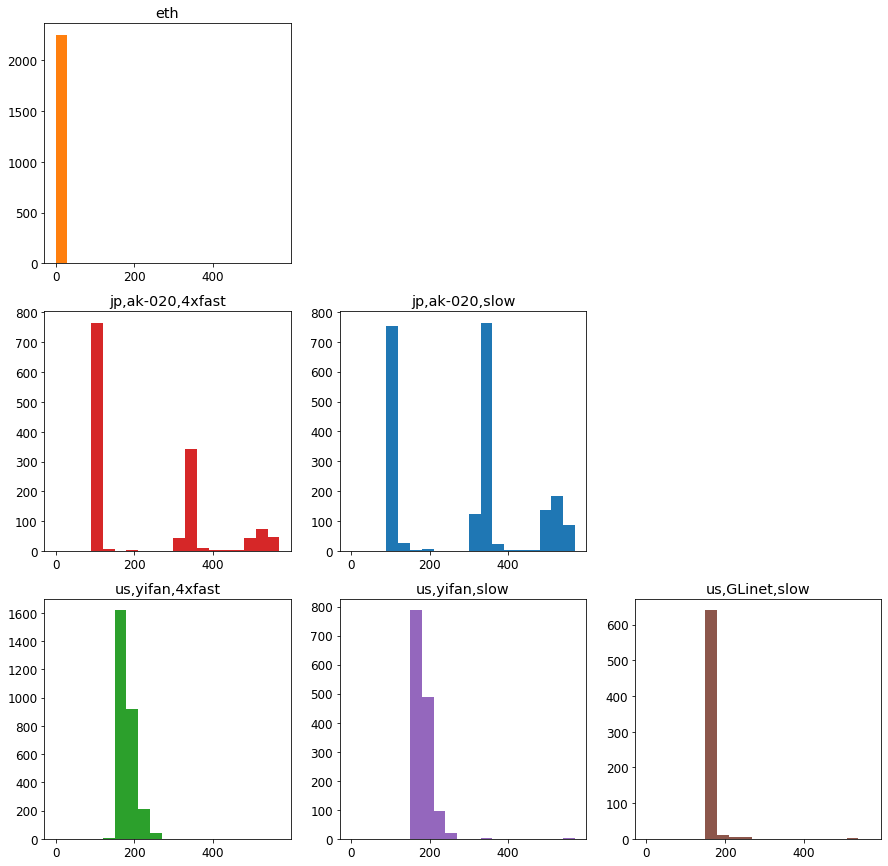

In [6]:
# histogram
bins_list = [x for x in range(0, 600, 30)]
titles_latencies = {
    'eth': (0, 0, latencies_by_sources_jst[0][2], 'tab:orange'),
    'None1': (0, 1, None, None),
    'None2': (0, 2, None, None),
    'jp,ak-020,4xfast': (1, 0, latencies_by_sources_jst[1][2], 'tab:red'),
    'jp,ak-020,slow': (1, 1, latencies_by_sources_jst[2][2], 'tab:blue'),
    'None3': (1, 2, None, None),
    'us,yifan,4xfast': (2, 0, latencies_by_sources_cdt[1][2], 'tab:green'),
    'us,yifan,slow': (2, 1, latencies_by_sources_cdt[2][2], 'tab:purple'),
    'us,GLinet,slow': (2, 2, latencies_by_sources_cdt[3][2], 'tab:brown'),
}

fig, axs = plt.subplots(3, 3, figsize=(15,15))
count = 0
for label, params in titles_latencies.items():
    r, c, latencies, color = params
    if latencies is None:
        axs[r, c].set_visible(False)
        continue
    axs[r, c].hist(latencies, bins = bins_list, color=color)
    axs[r, c].set_title(label)

plt.savefig('latency_summary.png')


In [8]:
# average latency
import pandas as pd

rows = []
for label, params in titles_latencies.items():
    r, c, latencies, color = params
    if latencies is None:
        continue
    
    rows.append([label, sum(latencies) / len(latencies)])

df = pd.DataFrame(rows, columns=['source', 'latency[ms]'])
df


,source,latency[ms]
0,eth,10.442510
1,"jp,ak-020,4xfast",232.315788
2,"jp,ak-020,slow",297.752537
3,"us,yifan,4xfast",176.852937
4,"us,yifan,slow",176.952770
5,"us,GLinet,slow",163.269426
